In [1]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import random 
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

In [2]:
# Maximum Loan Amount
# Dataset 
# URL: https://www.servicesaustralia.gov.au/age-component-for-loans-under-home-equity-access-scheme?context=22546
data = [("60", "$2,080"), ("61", "$2,160"), ("62", "$2,250"), ("63", "$2,340"), 
        ("64", "$2,430"), ("65", "$2,530"), ("66", "$2,630"), ("67", "$2,740"), 
        ("68", "$2,850"), ("69", "$2,960"), ("70", "$3,080"), ("71", "$3,200"), 
        ("72", "$3,330"), ("73", "$3,460"), ("74", "$3,600"), ("75", "$3,750"), 
        ("76", "$3,900"), ("77", "$4,050"), ("78", "$4,210"), ("79", "$4,380"), 
        ("80", "$4,560"), ("81", "$4,740"), ("82", "$4,930"), ("83", "$5,130"), 
        ("84", "$5,330"), ("85", "$5,550"), ("86", "$5,770"), ("87", "$6,000"), 
        ("88", "$6,240"), ("89", "$6,490"), ("90", "$6,750")]

df_MLA = pd.DataFrame(data, columns=["age", "value"])
df_MLA["value"] = df_MLA["value"].apply(lambda x: float(x.replace("$", "").replace(",", "")))
df_MLA["age"] = df_MLA["age"].apply(lambda x: int(x))

age = list(range(91, 121))
value = [6750] * len(age)
data = list(zip(age, value))
df = pd.DataFrame(data, columns=["age", "value"])
df["value"] = df["value"].apply(lambda x: float(x))

df_MLA= pd.concat([df_MLA, df], axis=0).reset_index(drop = True)
df_MLA = df_MLA.set_index('age')

def fun_MLA(age, security, df_MLA):
    age_component = df_MLA.loc[age, "value"]
    security_round = round(security, -4)
    security_div = security_round / 10000
    MLA = security_div * age_component
    return MLA

In [247]:
# Parameters 
W0 = 40000 # Initial Wealth
x = 66 # Starting Age
t0 = 2022 # The Last Period 

alpha = 0.0015 # Aging in Place Benefit
theta = 0.7 # Non-durable cons exp. share
epsilon = 1.25 # Intratemporal elasticity of subs.
sigma = 0.333 # Intertemporal elasticity of subs.
kappa = 6000 # Bequest motive curvature
b = 12 # Bequest motive intensity
beta = 0.97 #Discount factor

dp = 0.01  # Minimum Property depreciation (Annual House Expenditure)

S_0 = 193 # Avegrage living Space: remain to be changed
H_0 = 881200 # Average House Price: remain to be changed
pi_m_shift = 0.5 # Shift between the RM lending rate and the discounted variable mortgage rate (%)

lambda1 =  0.01 # Transaction Fees for seller
lambda2 = 0.03 # Transaction Fees for buyer
#real estate agents usually charge a commission of 1-2% of the sale price for property transactions.

In [248]:
# loading results from other files
ir = np.load('ir_annual_.npy')
dvmr = np.load('dvmr_annual_.npy')
hp =  np.load('house_annual_.npy')
cpi = np.load('cpi_annual_.npy')

df_hc = pd.read_csv('df_hc.csv')
df_hc.columns= [int(x) for x in df_hc.columns]

df_mt = pd.read_csv('df_mt.csv')
df_mt = df_mt.set_index('Unnamed: 0')
df_mt.index.name  = 'age'
df_mt.columns= [int(x) for x in df_mt.columns]

In [149]:
rmlr = (dvmr + pi_m_shift)*0.01+1
rmlr_cum = rmlr.cumprod()

In [150]:
def allowance_BAL_process(age_st,  dvmr_ , prop_RM_ = 1):
    A_t_array = []
    BAL_t_array = []
    BAL_previous = 0
    A_previous = 0 
    for i in range(0,55): 
        H_t = H_0 * hp[i] 
        age = age_st + i 
        MLA = fun_MLA(age, H_t, df_MLA)
        UB1_annual = prop_RM_ *MLA - BAL_previous * (1 +dvmr_[i])
        UB2_annual = 1.5 * 1063*26 * cpi[i]
        min_value = min(UB1_annual, UB2_annual)
        max_value = max(min_value, 0)
        BAL_previous = BAL_previous * (1 +dvmr_[i]) + max_value
        BAL_t_array.append(BAL_previous)
        A_t_array.append(max_value)
    return BAL_t_array, A_t_array

In [151]:
Dict_rmld= {}

rmld_1 = (dvmr + pi_m_shift)*0.01
rmld_2 = (dvmr + 1)*0.01
rmld_3 = dvmr*0.01
rmld_4 = np.full(55, 3.95)*0.01

Dict_rmld["rmld_1"] = rmld_1
Dict_rmld["rmld_2"] = rmld_2
Dict_rmld["rmld_3"] = rmld_3
Dict_rmld["rmld_4"] = rmld_4


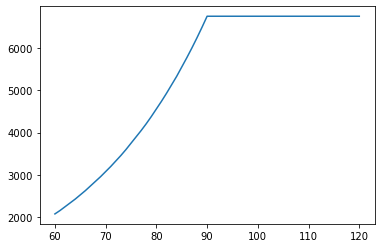

In [152]:
plt.plot(df_MLA)

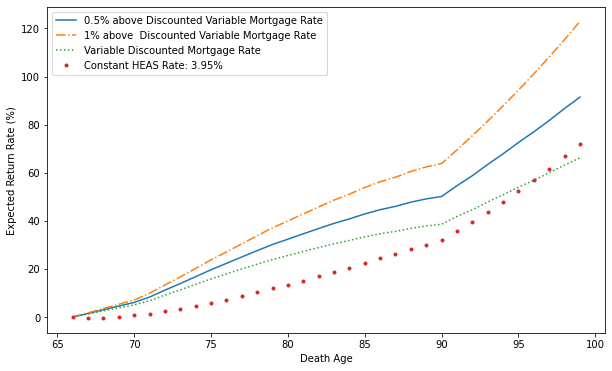

In [153]:
r_rate_arr = []

age_st = 66 

labels = ['0.5% above Discounted Variable Mortgage Rate',          '1% above  Discounted Variable Mortgage Rate',          'Variable Discounted Mortgage Rate',          'Constant HEAS Rate: 3.95%']

line_types = ['-', '-.', ':', '.']
plt.figure(figsize=(10, 6))
for key, value in Dict_rmld.items():
    r_rate_arr = []
    BAL_t_array, A_t_array  = allowance_BAL_process(age_st, Dict_rmld[key], prop_RM_ = 1)
    outfl_pre = 0 
    for i in range(0, 100 - age_st):
        BAL_ = BAL_t_array[i]
        outfl = outfl_pre + A_t_array[i]/np.cumprod(1 + ir * 0.01)[i]
        outfl_pre = outfl
        infl = min((1 - lambda1) * H_0 * hp[i], BAL_) / np.cumprod(1 + ir * 0.01)[i]
        rate = (infl - outfl) / outfl *100
        r_rate_arr.append(rate)
    plt.plot(list(range(age_st, 100)), r_rate_arr, line_types[list(Dict_rmld.keys()).index(key)],label=labels[list(Dict_rmld.keys()).index(key)])

plt.xlabel("Death Age")
plt.ylabel("Expected Return Rate (%)")
plt.legend(loc="best")
plt.show()

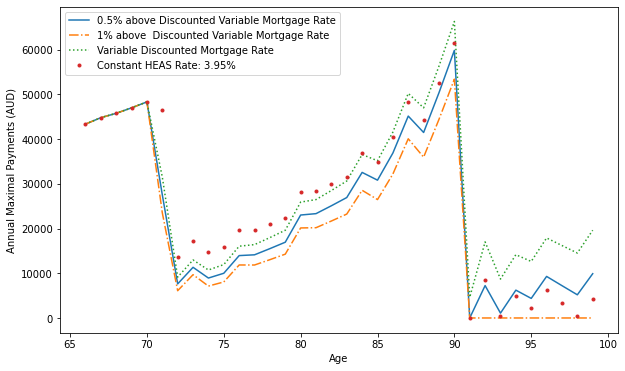

In [154]:
plt.figure(figsize=(10, 6))
for key, value in Dict_rmld.items():
    r_rate_arr = []
    BAL_t_array, A_t_array  = allowance_BAL_process(age_st, Dict_rmld[key], prop_RM_ = 1)
    plt.plot(list(range(age_st, 100)), A_t_array[0:34], line_types[list(Dict_rmld.keys()).index(key)],label=labels[list(Dict_rmld.keys()).index(key)])

plt.xlabel("Age")
plt.ylabel("Annual Maximal Payments (AUD)")
plt.legend(loc="best")
plt.show()

In [155]:
def mortality_rate(a, t):
    return np.exp(-0.332 * a + 0.332 * a * np.cos(np.exp(2.995 - a / t)) ** 2)

In [156]:
# import numpy as np
# import matplotlib.pyplot as plt

# a = np.linspace(100, 120, 31)
# t = np.linspace(2058, 2078, 31)

# X, Y = np.meshgrid(a, t)
# Z = mortality_rate(X, Y)

# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, Z, cmap='viridis')

# ax.set_xlabel("Age")
# ax.set_ylabel("Time")
# ax.set_zlabel("Mortality Rate")

# plt.show()


In [157]:
def omega(t,homeowner=True):
    
    if homeowner:
        A_t = t - x
        
    else:
        A_t = 0
        
    omega_t = np.exp(alpha * A_t)
    
    return omega_t


In [212]:
def U1(C_t, S_t,t,homeowner):
    omega_t =15/193*omega(t, homeowner)
    
    term1 = theta**(1 / epsilon) * C_t**((epsilon - 1) / epsilon)
    
    term2 = (1 - theta)**(1 / epsilon) * (omega_t * S_t )**((epsilon - 1) / epsilon)
#     term2 = 0
    utility = ((term1 + term2)**(epsilon / (epsilon - 1)))**(1 - (1 / sigma)) / (1 - (1 / sigma))
    
    return utility

In [213]:
def U2(W_tau_x):
    
    utility = b * (W_tau_x + kappa)**(1 - (1 / sigma)) / (1 - (1 / sigma))
    
    return utility

In [214]:
# def W_previous(W_t_plus_1, C_t, t):
#     t_ = t - t0
#     age_ = x + t_
#     HC_t = df_hc.loc[age_,t]
#     HE_t = 0 
#     r_t = ir[t_-1] * 0.01
#     Y_t = 1063*26 * cpi[t_-1]
#     W_t  = (W_t_plus_1 - Y_t)/(1 + r_t)+ C_t + HC_t + HE_t 
#     return W_t

In [215]:
# S_t = S_0

# V_array = [0]
# W_array = [0]
# C_array = [0]

# homeowner = 1
# t = 2057
# age_ = x + t - t0
# omega_t = omega(t, homeowner)
# C_star = 0
# W_t_plus_1 = W_array[0]

# C_t_upper = 30000*cpi[t-t0-1]*1.5
# C_t_lower = 30000*cpi[t-t0-1]*0.5

# pt = 1 - df_mt.loc[age_ ,t]
# qt = df_mt.loc[age_ ,t]
 
# H_t = H_0 * hp[t-t0-1] 
# BAL_0 = fun_MLA(age_, H_0, df_MLA)
# BAL_t = rmlr_cum[t-t0-1] * BAL_0
# SP_House = max((1-lambda1)* H_t - BAL_t,0) # Sales Proceedings 

# #         V_t_plus_1 = beta * (pt * V(t + 1, W_t_plus_1, homeowner)[0] + qt * U2(W_t_plus_1))
# #     V_t = U1(C_t, S_t, t, homeowner) + V_t_plus_1

In [216]:
# V_star = -np.inf
# V_array = [beta * U2((W_t_plus_1 + SP_House)/cpi[t-t0-1])]
# W_array = [0]
# C_array = [0]
# for C_t in range(0, int(C_t_upper), 100):
#     V_t_plus_1 = beta * (pt * V_array[0] + qt * U2((W_t_plus_1 + SP_House)/cpi[t-t0-1]))
#     V_t = U1(C_t/cpi[t-t0-1], S_t, t, homeowner) + V_t_plus_1 
#     W_star = W_previous(W_t_plus_1, C_star, t)
#     V_array.append
#     W_array = [W_star] + W_array 
#     C_array = [C_star] + C_array

In [217]:
def W_next(W_t, C_t, A_t ,t):
    t_ = t - t0
    age_ = x + t_
    HC_t = df_hc.loc[age_,t]
    HE_t = dp * H_0 * cpi[t_-1]
    r_t = ir[t_-1] * 0.01
    Y_t = 1063*26 * cpi[t_-1]
    W_t_plus_1 = (W_t - C_t - HC_t - HE_t + A_t) * (1 + r_t) + Y_t 
    return W_t_plus_1

In [218]:
Dict_At = {}
for prop_RM_ in [0, 1/3, 2/3, 1]:
    for rmld_name, rmld_value in Dict_rmld.items():
        BALt,At = allowance_BAL_process(66, Dict_rmld["rmld_4"], prop_RM_)
        key = f"propRM_{prop_RM_}"
        Dict_At[key] = At



In [219]:
# One Consumption Pattern Single
from scipy.interpolate import CubicSpline
ages = list(range(65, 101))

clvl_arr = [35000,30000, 27500,25000, 22500]

dict_cfct = {}

cfct1 = np.array([1,1,1,1])
cfct2 = np.array([1,0.95, 0.85,0.8])
cfct3 = np.array([1,0.9, 0.75,0.65])
cfct4 = np.array([1,0.75, 0.55,0.475])
cfct5 = np.array([1,0.65, 0.4, 0.35])

dict_cfct['cfct1'] = cfct1
dict_cfct['cfct2'] = cfct2
dict_cfct['cfct3'] = cfct3
dict_cfct['cfct4'] = cfct4
dict_cfct['cfct5'] = cfct5


In [220]:
def cal_W_arr(W_,consume_pattern_arr_,A_arr_):
    
    W_arr_= []
    
    for t in range(2023,2058):
        W_ = W_next(W_, consume_pattern_arr_[t-t0-1] *cpi[t-t0-1], A_arr_[t-t0-1],t)
        W_arr_.append(W_)
        
    return W_arr_

In [221]:
def find_neg(W_arr_): 
    first_neg = -np.inf
    for i in range(len(W_arr_)):
        if W_arr_[i] < 0:
            first_neg = i
            break
    return(first_neg)


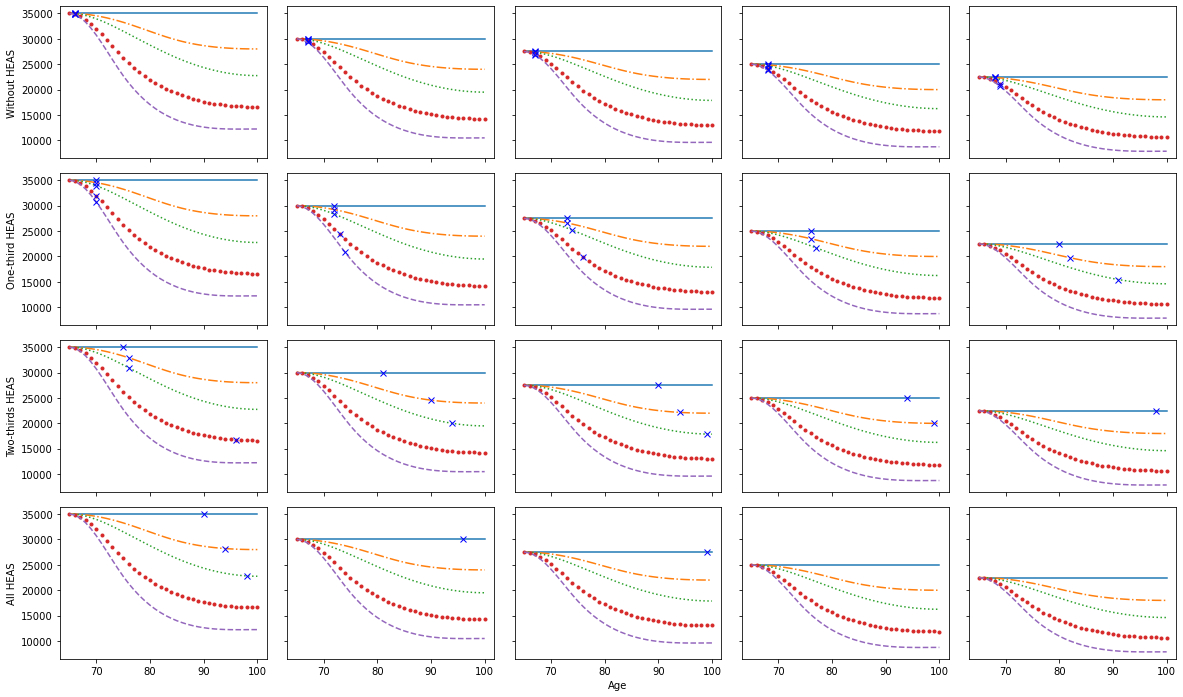

In [222]:
fig, axs = plt.subplots(nrows=4, ncols=5, sharex = True, sharey = True,  figsize=(20, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.1)


for k, A_t_key in enumerate(Dict_At):
    A_t = Dict_At[A_t_key]
    

    for j, clvl in enumerate(clvl_arr):
        data_list = []
        for key, value in dict_cfct.items():
            data = {'age': [65, 75, 85, 100],
                    'Consumption': clvl * value}
            data_list.append(data)

        line_types = ['-', '-.', ':', '.', '--']
        for i, data in enumerate(data_list):
            cs = CubicSpline(data['age'],data['Consumption'], bc_type = 'clamped')
            consume_pattern_arr = cs(ages)
            axs[k, j].plot(ages, consume_pattern_arr, line_types[i])
            W_arr = cal_W_arr(W0,consume_pattern_arr,A_t)
            age_index = find_neg(W_arr)
            if age_index >= 0:
                axs[k, j].plot(age_index + 65, consume_pattern_arr[age_index], 'bx')

axs[3, 2].set_xlabel("Age")
axs[0, 0].set_ylabel("Without HEAS")
axs[1, 0].set_ylabel("One-third HEAS")
axs[2, 0].set_ylabel("Two-thirds HEAS")
axs[3, 0].set_ylabel("All HEAS")
plt.show()


In [223]:
def generate_consume(ages_ = list(range(65, 101)), total_years_= 55):
    array = []
    for i in range(8):
        array.append(round(40000*random.uniform(0.25, 1.25), 2))
#     array.sort(reverse=True)
    data = {'age': [65, 70, 75, 80,85,90, 95,100],
            'Consumption': array}
    cs = CubicSpline(data['age'],data['Consumption'], bc_type = 'clamped')
    consume_pattern_arr = cs(ages_)  
    last_element = consume_pattern_arr[-1]
    num_elements_to_add = total_years_ - 35
    new_elements = np.full(num_elements_to_add, last_element)
    return  np.concatenate((consume_pattern_arr, new_elements))

In [224]:
def cash_on_hand(prop_RM_,age_):
    BAL_t_array, A_t_array  = allowance_BAL_process(age_st, Dict_rmld['rmld_4'], prop_RM_)
    W0_ = 40000
    W_arr_= []
    while True:
        consume_pattern_arr_ = generate_consume()
        W = W0_
        for t in range(2023,2078):
            W = W_next(W, consume_pattern_arr_[t-2023]*cpi[t-t0-1], A_t_array[t-t0-1] ,t)
            W_arr_.append(W) 
        if find_neg(W_arr_)< 0:
            break
        else:
            W_arr_= []           
    return consume_pattern_arr_, W_arr_      


In [225]:
def Values_Last(consume_pattern_arr_, W_arr_,t_,homeowner_,prop_RM_,age_):
    BAL_t_array, A_t_array  = allowance_BAL_process(age_st, Dict_rmld['rmld_4'], prop_RM_)
    BAL_t_= BAL_t_array[t_-t0-1] 
    H_t =H_0 * hp[t_-t0-1] 
    SP_House = max((1-lambda1)* H_t - BAL_t_,0)
    V  = U1(consume_pattern_arr_[-1], S_t, t_, homeowner_) +  U2(( W_arr_[-1] + SP_House)/cpi[t_-t0-1])
    return V

    

In [226]:
def add_element_to_beginning(array, element):
    return np.concatenate((np.array([element]), array))

In [227]:
# V_best = -np.inf
# Bequest = -np.inf

# C_best = []
# W_best = []
# V_best_arr = []

# prop_RM_ = 1
# # as long as it is smaller than fun_MLA(x,H_0,df_MLA)
# age_st = 66
# S_t = S_0

# BAL_t_array, A_t_array  = allowance_BAL_process(age_st, Dict_rmld['rmld_4'], prop_RM_)

# for i in range(1,5000):
#     consume_pattern_arr_ , W_arr_ =  cash_on_hand(prop_RM_,age_st)

#     V_next  = Values_Last(consume_pattern_arr_, W_arr_,2077,1,prop_RM_,age_st)
#     V_best_arr_sub = []
#     V_best_arr_sub.append(V_next)
#     for tt in range(0,54):

#         t = t0 + 54 - tt
        
#         age_ = x + t - t0
        
#         qt =  mortality_rate(age_,t)
#         pt = 1- qt
        
#         C_t = consume_pattern_arr_[t-t0-1] # Adjusted
#         H_t = H_0 * hp[t-t0-1] 
#         BAL_t = BAL_t_array[t-t0-1]
        
#         SP_House = max((1-lambda1)* H_t - BAL_t,0) # Sales Proceedings 
        
#         V_t_plus_1 = beta * (pt * V_next + qt * U2(( W_arr_[t-t0-1] + SP_House)/cpi[t-t0-1]))
#         V_t = U1(C_t, S_t, t, 1) + V_t_plus_1
        
#         V_next = V_t
#         V_best_arr_sub = add_element_to_beginning(V_best_arr_sub, V_t)
        
#     if  V_t > V_best:
#         V_best = V_t
#         C_best = consume_pattern_arr_
#         W_best = W_arr_
#         V_best_arr_ = V_best_arr_sub
# #         Bequest_best = W_best[-1] +  SP_House
# #         SP_House_best = SP_House


In [249]:
from joblib import Parallel, delayed

prop_RM_ = 1
# as long as it is smaller than fun_MLA(x,H_0,df_MLA)
age_st = 66
S_t = S_0
BAL_t_array, A_t_array  = allowance_BAL_process(age_st, Dict_rmld['rmld_4'], prop_RM_)


def process_iteration(i):
    consume_pattern_arr_, W_arr_ = cash_on_hand(prop_RM_, age_st)
    V_next = Values_Last(consume_pattern_arr_, W_arr_, 2077, 1, prop_RM_, age_st)
    V_best_arr_sub = [V_next]

    for tt in range(0, 54):
        t = t0 + 54 - tt
        age_ = x + t - t0
        qt = mortality_rate(age_, t)
        pt = 1 - qt
        C_t = consume_pattern_arr_[t - t0 - 1]
        H_t = H_0 * hp[t - t0 - 1]
        BAL_t = BAL_t_array[t - t0 - 1]
        SP_House = max((1 - lambda1) * H_t - BAL_t, 0)
        V_t_plus_1 = beta * (pt * V_next + qt * U2((W_arr_[t - t0 - 1] + SP_House) / cpi[t - t0 - 1]))
        V_t = U1(C_t, S_t, t, 1) + V_t_plus_1
        V_next = V_t
        V_best_arr_sub = add_element_to_beginning(V_best_arr_sub, V_t)

    return V_t, consume_pattern_arr_, W_arr_, V_best_arr_sub

In [250]:
results = Parallel(n_jobs=-1)(delayed(process_iteration)(i) for i in range(1, 10000))

In [251]:
V_best = -np.inf
Bequest = -np.inf

for V_t, consume_pattern_arr_, W_arr_, V_best_arr_sub in results:
    if V_t > V_best:
        V_best = V_t
        C_best = consume_pattern_arr_
        W_best = W_arr_
        V_best_arr_ = V_best_arr_sub

In [252]:
C_best_RM = C_best
V_best_RM = V_best_arr_ 
W_best_RM = W_best

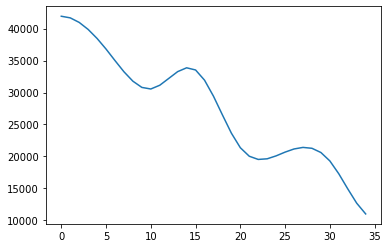

In [253]:
plt.plot(C_best_RM[0:35])

In [254]:
# generate new points of ages after taking a new strategy
def generate_three_integers(age_):
    period = (100 - age_) / 3
    integers = np.linspace(age_, 100, 4, dtype=int)
    return integers


In [255]:
def W_next_rent(W_t, C_t, t, S_new):
    t_ = t - t0
    age_ = x + t_
    HC_t = df_hc.loc[age_,t]
    HE_t = 0 
    r_t = ir[t_-1] * 0.01
    Y_t = 1063*26 * cpi[t_-1]
    H_t = H_0 * hp[t-t0-1] 
    RC_t = S_new/S_0 * H_0 * 0.03 * cpi[t_-1]
    
    W_t_plus_1 = (W_t - C_t  -  RC_t ) * (1 + r_t) + Y_t
    return W_t_plus_1

In [256]:
def sel_rent_process(age_st, age_, prop_RM_, living_size, W_age_, total_years_ = 55):
    BAL_t_array, A_t_array  = allowance_BAL_process(age_st, Dict_rmld['rmld_4'], prop_RM_ = 1)
   
    t = age_ - age_st + t0                                 
    H_t = H_0 * hp[t-t0-1] 
    BAL_t = BAL_t_array[t-t0-1] 
    SP_House_ = max((1-lambda1)* H_t - BAL_t,0) # Sales Proceedings 
                                            
    W0_ = W_age_ + SP_House_ 
    W_arr_= []
    while True:
        W_ = W0_
        array = []
        for i in range(4):
            array.append(round(50000*random.uniform(0.25, 1.25), 2))
    #     array.sort(reverse=True)
        data = {'age': generate_three_integers(age_),
                'Consumption': array}
        cs = CubicSpline(data['age'],data['Consumption'], bc_type = 'clamped')
        consume_pattern_arr_new= cs(np.arange(age_, 101))  

        last_element = consume_pattern_arr_new[-1]
        num_elements_to_add = total_years_ - 35
        new_elements = np.full(num_elements_to_add, last_element)
        consume_pattern_arr_new= np.concatenate((consume_pattern_arr_new, new_elements))

        for t_new in range(t,2077):
            W_ = W_next_rent(W_, consume_pattern_arr_new[t_new-t]*cpi[t_new-t0-1], t,living_size)
            W_arr_.append(W_) 
        if find_neg(W_arr_) < 0:
            break
        else:

            W_arr_= []           
    return consume_pattern_arr_new, W_arr_      

    
    

In [257]:
def Values_Last_rent(consume_pattern_arr_, W_arr_,t_,S_new):
    V  = U1(consume_pattern_arr_[-1], S_new, t_, 0) +  U2(W_arr_[-1]/cpi[t-t0-1])
    return V

In [258]:
def RM_Rent_time(age_st , age_, prop_RM_, S_t , W_best_RM, total_years_ = 55): 
    age_gap = age_  - age_st
    V_best = -np.inf
    Bequest = -np.inf
    C_best = []
    W_best = []
    V_best_arr = []

    W_age_ = W_best_RM[age_- age_st]

    for i in range(1,10000):

        consume_pattern_arr_, W_arr_ = sel_rent_process(age_st, age_, prop_RM_,S_t , W_age_, total_years_ = 55)

        V_next  = Values_Last_rent(consume_pattern_arr_, W_arr_,2078, S_t ) 

        for tt in range(0,54 - age_gap):

            t = t0 + 54 - tt

            age_ = age_st + t - t0

            qt =  mortality_rate(age_,t)
            pt = 1- qt

            C_t = consume_pattern_arr_[- tt - 1] # Adjusted


            V_t_plus_1 = beta * (pt * V_next + qt * U2(W_arr_[- tt - 1] /cpi[t-t0-1]))
            V_t = U1(C_t, S_t, t, 0) + V_t_plus_1

            V_next = V_t

        if  V_t > V_best:
            V_best = V_t
            C_best = consume_pattern_arr_
            W_best = W_arr_
        return V_best, C_best, W_best
        

In [259]:
# first_age = None
# first_age_arr = []
# Dict_rm2rent_C = {}

# for size_prop in np.linspace(1/10, 8/10, num=8):
#     for age_ in range(67, 98):
#         RM_Rent_V, C_best, _ = RM_Rent_time(66, age_, 1, size_prop * S_0, W_best_RM, total_years_=55)
#         if RM_Rent_V > V_best_RM[age_ - 66]:
#             first_age = age_
#             break
#     first_age_arr.append(first_age) 
#     Dict_rm2rent_C[size_prop] = C_best
# print(first_age_arr)

In [260]:
def process_size_prop(size_prop):
    first_age = None

    for age_ in range(67, 98):
        RM_Rent_V, C_best, _ = RM_Rent_time(66, age_, 1, size_prop * S_0, W_best_RM, total_years_=55)
        if RM_Rent_V > V_best_RM[age_ - 66]:
            first_age = age_
            break

    return first_age, C_best, size_prop

In [261]:
size_props = np.linspace(1/20, 13/20, num=12)
results = Parallel(n_jobs=-1)(delayed(process_size_prop)(size_prop) for size_prop in size_props)

In [271]:
first_age_smallest = 100 
for first_age, C_best, size_prop in results:
    if first_age is not None: 
        if first_age < first_age_smallest:
            C_best_rent = C_best
            size_prop_rent =  size_prop
            first_age_smallest = first_age 

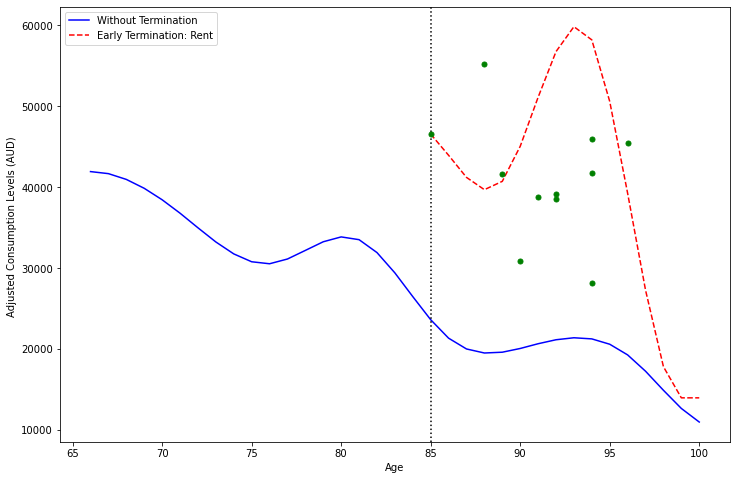

In [333]:


plt.figure(figsize=(12, 8)) 
x_values = np.arange(66, 101)

# Truncate C_best_RM to the first 36 elements (0 to 35)
y_values = C_best_RM[0:35]

# Plot the graph
plt.plot(x_values, y_values,color='b',label='Without Termination')

x_values_rent = np.arange(85, 101)
y_values_rent = C_best_rent[1:len(x_values_rent)+1]
plt.plot(x_values_rent, y_values_rent, label='Early Termination: Rent', color='r',linestyle='--')

plt.xlabel('Age')
plt.ylabel('Adjusted Consumption Levels (AUD) ')

plt.axvline(x=85, ymin=0, ymax=C_best_rent[1], color='k', linestyle=':')


for first_age, C_best, size_prop in results:
    if first_age is not None:
        plt.plot(first_age, C_best[1], marker='o',  color='g',markersize=5)
#         plt.annotate(f'{size_prop:.2f}', (first_age, C_best[1]), textcoords="offset points", xytext=(0,5), ha='center')


plt.legend()

plt.show()

In [ ]:
def process_size_prop_rm2rm(size_prop):
    first_age = None

    for age_ in range(67, 98):
        RM_Rent_V, C_best, _ = RM_RM_time(66, age_, 1, 1, size_prop * S_0, W_best_RM, total_years_=55)
        if RM_Rent_V > V_best_RM[age_ - 66]:
            first_age = age_
            break

    return first_age, C_best, size_prop

In [ ]:
def RM_RM_time(age_st , age_, prop_RM_old, prop_RM_new, S_t , W_best_RM, total_years_ = 55): 
    age_gap = age_  - age_st
    
    V_best = -np.inf
    Bequest = -np.inf
    C_best = []
    W_best = []
    V_best_arr = []

    W_age_ = W_best_RM[age_- age_st]

    for i in range(1,10000):

        #consume_pattern_arr_, W_arr_ = sel_rent_process(age_st, age_, prop_RM_,S_t , W_age_, total_years_ = 55)
        #consume_pattern_arr_, W_arr_ = cash_on_hand(prop_RM_, age_st)
        consume_pattern_arr_, W_arr_ = sel_buy_process(prop_RM_, age_st)
        #V_next  = Values_Last_rent(consume_pattern_arr_, W_arr_,2078, S_t ) 
        #V_next = Values_Last(consume_pattern_arr_, W_arr_, 2077, 1, prop_RM_, age_st)
        

        for tt in range(0,54 - age_gap):

            t = t0 + 54 - tt

            age_ = age_st + t - t0

            qt =  mortality_rate(age_,t)
            pt = 1- qt

            C_t = consume_pattern_arr_[- tt - 1] # Adjusted


            V_t_plus_1 = beta * (pt * V_next + qt * U2(W_arr_[- tt - 1] /cpi[t-t0-1]))
            V_t = U1(C_t, S_t, t, 0) + V_t_plus_1

            V_next = V_t

        if  V_t > V_best:
            V_best = V_t
            C_best = consume_pattern_arr_
            W_best = W_arr_
        return V_best, C_best, W_best

In [ ]:
    consume_pattern_arr_, W_arr_ = cash_on_hand(prop_RM_, age_st)
    V_next = Values_Last(consume_pattern_arr_, W_arr_, 2077, 1, prop_RM_, age_st)
    V_best_arr_sub = [V_next]

    for tt in range(0, 54):
        t = t0 + 54 - tt
        age_ = x + t - t0
        qt = mortality_rate(age_, t)
        pt = 1 - qt
        C_t = consume_pattern_arr_[t - t0 - 1]
        H_t = H_0 * hp[t - t0 - 1]
        BAL_t = BAL_t_array[t - t0 - 1]
        SP_House = max((1 - lambda1) * H_t - BAL_t, 0)
        V_t_plus_1 = beta * (pt * V_next + qt * U2((W_arr_[t - t0 - 1] + SP_House) / cpi[t - t0 - 1]))
        V_t = U1(C_t, S_t, t, 1) + V_t_plus_1
        V_next = V_t
        V_best_arr_sub = add_element_to_beginning(V_best_arr_sub, V_t)


In [ ]:
def cash_on_hand(prop_RM_,age_):
    BAL_t_array, A_t_array  = allowance_BAL_process(age_st, Dict_rmld['rmld_4'], prop_RM_)
    W0_ = 40000
    W_arr_= []
    while True:
        consume_pattern_arr_ = generate_consume()
        W = W0_
        for t in range(2023,2078):
            W = W_next(W, consume_pattern_arr_[t-2023]*cpi[t-t0-1], A_t_array[t-t0-1] ,t)
            W_arr_.append(W) 
        if find_neg(W_arr_)< 0:
            break
        else:
            W_arr_= []           
    return consume_pattern_arr_, W_arr_ 

def generate_consume(ages_ = list(range(65, 101)), total_years_= 55):
    array = []
    for i in range(8):
        array.append(round(40000*random.uniform(0.25, 1.25), 2))
#     array.sort(reverse=True)
    data = {'age': [65, 70, 75, 80,85,90, 95,100],
            'Consumption': array}
    cs = CubicSpline(data['age'],data['Consumption'], bc_type = 'clamped')
    consume_pattern_arr = cs(ages_)  
    last_element = consume_pattern_arr[-1]
    num_elements_to_add = total_years_ - 35
    new_elements = np.full(num_elements_to_add, last_element)
    return  np.concatenate((consume_pattern_arr, new_elements))


def allowance_BAL_process(age_st,  dvmr_ , prop_RM_ = 1):
    A_t_array = []
    BAL_t_array = []
    BAL_previous = 0
    A_previous = 0 
    for i in range(0,55): 
        H_t = H_0 * hp[i] 
        age = age_st + i 
        MLA = fun_MLA(age, H_t, df_MLA)
        UB1_annual = prop_RM_ *MLA - BAL_previous * (1 +dvmr_[i])
        UB2_annual = 1.5 * 1063*26 * cpi[i]
        min_value = min(UB1_annual, UB2_annual)
        max_value = max(min_value, 0)
        BAL_previous = BAL_previous * (1 +dvmr_[i]) + max_value
        BAL_t_array.append(BAL_previous)
        A_t_array.append(max_value)
    return BAL_t_array, A_t_array

def W_next(W_t, C_t, A_t ,t):
    t_ = t - t0
    age_ = x + t_
    HC_t = df_hc.loc[age_,t]
    HE_t = dp * H_0 * cpi[t_-1]
    r_t = ir[t_-1] * 0.01
    Y_t = 1063*26 * cpi[t_-1]
    W_t_plus_1 = (W_t - C_t - HC_t - HE_t + A_t) * (1 + r_t) + Y_t 
    return W_t_plus_1

def Values_Last(consume_pattern_arr_, W_arr_,t_,homeowner_,prop_RM_,age_):
    BAL_t_array, A_t_array  = allowance_BAL_process(age_st, Dict_rmld['rmld_4'], prop_RM_)
    BAL_t_= BAL_t_array[t_-t0-1] 
    H_t =H_0 * hp[t_-t0-1] 
    SP_House = max((1-lambda1)* H_t - BAL_t_,0)
    V  = U1(consume_pattern_arr_[-1], S_t, t_, homeowner_) +  U2(( W_arr_[-1] + SP_House)/cpi[t_-t0-1])
    return V
